# 3. Teoría de la estimación
# 3.1. Función de verosimilitud

<p align="right">
Autor: Emmanuel Alcalá
<br>
<a href="https://scholar.google.com.mx/citations?hl=en&user=3URusCgAAAAJ&view_op=list_works&sortby=pubdate">Google Scholar</a>
</p>

<p align="left">
<br>
<a href="https://jealcalat.github.io/Analisis_multivariado/">Regresar a la página del curso</a>
</p>

---

Algunas funciones de probabilidad y densidad y su definición en R:

| Función  | Nombre | Comando en R  | Argumentos |
|---|---|---|---|
| $p(x)=\binom{n}{k}p^k(1-p)^{n-k}$  | Binomial   | `dbinom(x, size, prob)` | $n$=size, $k$=x, $p$=prob |
| $p(x) = \frac{{e^{ - \lambda } \lambda ^x }}{x!}$ | Poisson    | `dpois(x, lambda)` |$x$=x, $\lambda$=lambda |
| $p(x)=\frac{1}{b-a}$  |  Uniforme  | `dunif(x, min, max)` | $x$=x, $a$=min, $b$=max|
| $p(x)=\frac{1}{\sigma\sqrt{2\pi \sigma}}\exp\left\{-\frac{(x-\mu)^2}{2\sigma^2} \right\} $  |  Normal    | `dnorm(x, mean, sd)` | $x$=x, $\mu$=mean, $\sigma$=sd |



## ¿Por qué?

>**Modelos de probabilidad** ¿Cuál es la probabilidad de observar los *datos* dado los *parámetros* que conocemos?

>**Modelos estadísticos**:  ¿Cuáles son los valores más *plausibles* de los *parámetros* dado los *datos* que observamos? (Notar que no dice "más probables").

<figure>
<p align="center">
  <img src="img/2022-08-29-21-59-31.png" width='40%' />
      <figcaption>Probabildad vs estadística</figcaption>
</p>
</figure>

**Ejemplo:**
¿Cuán probable es que obtengamos 9 "Caras" (1) si lanzamos una moneda "justa" ( $p=0.5$ ) 10 veces? 

La pregunta es sobre 10 lanzamientos, y cada uno de ellos es un experimento aleatorio, que da lugar a una VA discreta cuyos valores solo pueden ser dos, $\{0,1\}$ (por ejemplo). A cada uno de estos lanzamientos le llamamos *ensayo de Bernoulli* (un ensayo con resultados de tipo éxito/fracaso).

La VA discreta que resulta de los 10 lanzamientos tiene *distribución binomial*, que se usa para modelar el número de éxitos (e.g., valores en los que $X=1$) en una muestra aleatoria *con reemplazo* de tamaño $n$. 

Su distribución es

$$
  p(k, n, \theta) = \Pr(X = k) = \binom{n}{k}\theta^k(1-\theta)^{n-k}
$$

En donde $\binom{n}{k}$ es el coeficiente binomial

$$
  \binom{n}{k} = \frac{n!}{k!(n-k)!}
$$

$n$ es el tamaño de la muestra (el total de ensayos), $k$ el número de éxitos, y $\theta$ un parámetro de la distribución que define la probabilidad de éxito (y por lo tanto, define la forma de la distribución y el valor más probable). Por ejemplo, si nuestra moneda es justa, tendrá una $\theta=0.5$. 

La media de una distribución binomial es $n\times \theta$, esto significa que si lanzamos 10 veces una moneda con $\theta=0.5$, el valor más probable de éxitos será $0.5\times 10 = 5$.

En R podríamos obtener la probabilidad que buscamos de la siguiente manera:

In [11]:
dbinom(
  x = 9, # k éxitos
  size = 10, # ensayos de bernoulli
  prob = 0.5
)


[1] 0.009765625

Es decir, la probabilidad de tener 9 éxitos, dado que $\theta=0.5, n=10$, es de apenas ~0.01, una probabilidad muy baja.

¿Cuál sería la probabilidad de conseguir 6 éxitos bajo las mismas asunciones?

In [12]:
dbinom(x = 6, size = 10, prob = 0.5)


[1] 0.2050781

¿Y dos éxitos?

In [13]:
dbinom(x = 2, size = 10, prob = 0.5)


[1] 0.04394531

La distribución de la binomial con estos parámetros tiene la siguiente forma

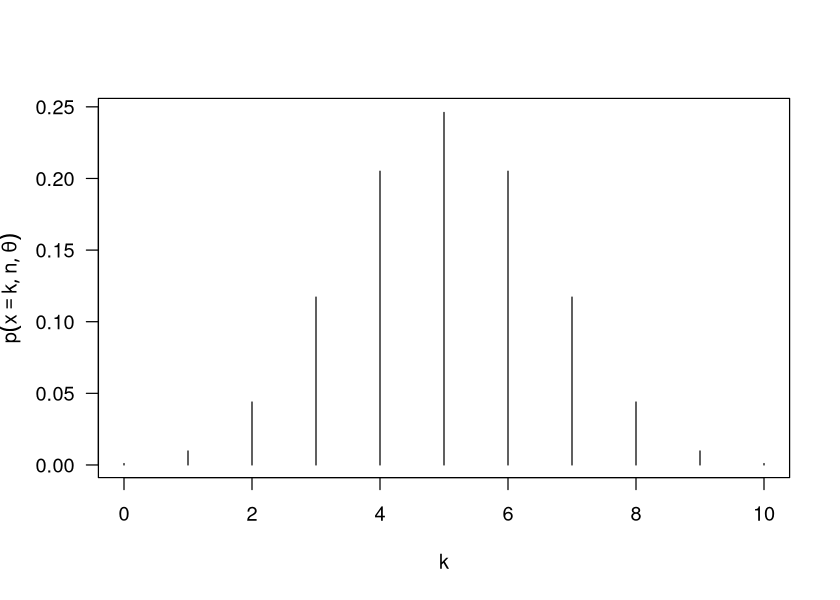

In [14]:
par(las = 1)
options(repr.plot.width = 7, repr.plot.height = 5)
exitos <- 0:10
plot(
  exitos,
  dbinom(exitos, size = 10, prob = .5),
  type = "h",
  xlab = "k",
  ylab = expression(p(x == k, n, theta))
)


La probabilidad de 9 éxitos es menor a la probabilidad de 2 y de 6 éxitos.

Valgan estos dos ejemplos para asumir lo siguiente:

>Si la distribución tiene fijo un parámetro ($\theta=0.5$), es más probable una cantidad de éxitos que otra (e.g., 6 éxitos vs 9 éxitos).

Ahora, supongamos que desconocemos $\theta$, pero obtenemos 9 éxitos en 10 lanzamientos. 

1. ¿Hay alguna forma de estimar el valor de $\theta$ que originó, o pudo haber originado, este resultado? 
2. Si tenemos la hipótesis de que $\theta\neq 0.5$, ¿hay una forma en la que podamos obtener evidencia de esta hipótesis?

A ambas la respuesta es sí, pero para contestarlo, necesitamos la función de verosimilitud.



ver https://github.com/mebucca/cda_soc3070/blob/master/slides/class_4/class_4.Rmd

## Función de verosimilitud $L(\theta \mid \mathbf{x})$

La letra $L$ proviene de *likelihood*, que en español se traduce normalmente como verosimilitud o inlcuso como *credibilidad*. 

Si tenemos una muestra aleatoria $X_1, X_2, \dots, X_n$, la función de verosimilitud se define como la función de densidad conjunta

$$
  L(\theta \mid \mathbf{x}) = f(x_1, x_2, \dots, x_n;\theta)
$$

Abreviaremos $L(\theta)$ simplemente como $L(\theta)$

>Nota: *parece* que estamos definiendo la función de verosimilitud como la función de densidad conjunta, pero hay una diferencia importante. La función de densidad conjunta toma como fijo $\theta$, y lo que varía es $\mathbf{x}$, pero en la función de verosimilitud $\mathbf{x}$ ya fue observado, por lo que es fijo, y consideramos que $\theta$ varía sobre todos los posibles valores. 

Si $X_1, X_2, \dots, X_n$ son muestras independientes e idénticamente distribuidas (i.i.d), la función de densidad conjunta es

$$
  f(X_1, X_2, \dots, X_n \mid \theta)=f(X_1\mid \theta)\times f(X_2\mid \theta)\times\cdots \times f(X_n\mid \theta) = \prod_{i=1}^{n}f(X_i\mid \theta) \tag{1}
$$

Y la función de verosimilitud

$$
  L(\theta) = \prod_{i=1}^{n}f(X_i\mid \theta) \tag{2}
$$

Para algunos problemas, la función de log-verosimilitud, $\mathcal{l}(\theta)$ es más conveniente, dado que es más sencillo de trabajar con sumas que con productos y, además, la transformación logarítmica es monotónica.

$$
  \mathcal{l}(\theta) = \log \prod_{i=1}^{n}f(X_i\mid \theta) = \sum_{i=1}^{n}f(X_i\mid \theta)\tag{3}
$$

La función de verosimilitud puede ser usada para cuantificar la evidencia que tenemos en favor de una hipótesis. Retomando el ejemplo de lanzamientos de monedas, ¿qué tan *creíble* o verosímil es que 9 de 10 lanzamientos hayan sido caras (éxitos) *dado que* $\theta=0.5$? ¿Es menos, o más creíble, haber obtenido 9/10 con un $\theta=0.5$?

Obtendremos primero la verosimilitud $L(\theta=0.5)$ para esta distribución. 

Considera una muestra aleatoria de $n=10$ ensayos de Bernoulli $x_1,\dots, n_{10}$, cada uno con distribución

$$
  f(x) = \theta^x(1-\theta)^{1-x}\quad \text{ con } x = 0,1
$$

La función de verosimilitud es

$$
  L(\theta) =f(x_1,\ldots,x_{10};\theta)= \prod_{i=1}^n\theta^{x_i}(1-\theta)^{1-x_i}=
  \theta^{\sum_i x_i}(1-\theta)^{n-\sum_i x_i}
$$

Dado que $\sum_{i=1}^{10} x_i = 9$, y $n=10$, $L(\theta)=\theta^9(1-\theta)^{10-9}$

Para $\theta=0.5$, $L(\theta=0.5)=0.5^9(1-0.5)=0.00097$. 

Para $\theta=0.9$,$L(\theta=0.9)=0.9^9(1-0.9)=0.038$.

Si obtenemos la razón de ambas, $L(\theta_2)/L(\theta_1)$ obtenemos un valor que nos dice cuántas veces más verosímil es $\theta_2$ vs $\theta_1$.

Gráficamente se vería así

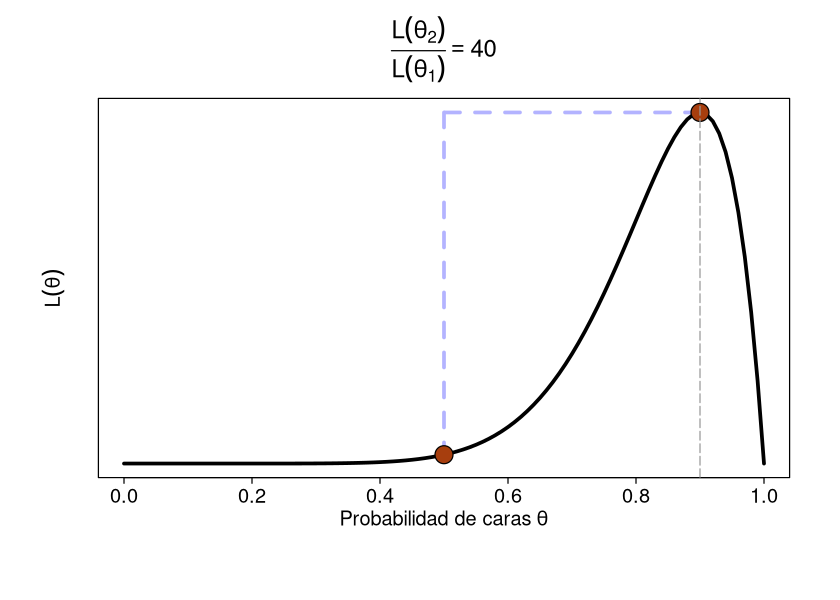

In [11]:
source("../r_scripts/utilities.r")
par(mgp = c(1.2, 0.25, 0))
options(repr.plot.width = 7, repr.plot.height = 5)
k <- 9
n <- 10
theta_1 <- 0.5
theta_2 <- 0.9
like_binom_plot(k, n, theta_2, theta_1)

# 3.2 Máxima verosimilitud

Hasta aquí la motivación del uso de las funciones de verosimilitud. Ahora veamos más formalmente la técnica para estimar parámetros, la estimación por máxima verosimilitud (EMV, y en inglés MLE). 

El problema de la MLE consiste en lo siguiente. Sea $X_1, X_2, \dots, X_n$ una muestra aleatoria de variables i.i.d. con distribución conjunta $L(\theta\mid X_1,\dots,X_n)$. El estimador de máxima verosimilitud de $\theta$ es la solución al problema de optimización

$$
  \theta^* = \argmax L(\theta\mid X_1,\dots,X_n ) \tag{4}
$$

Caveat: este método impone una restricción fuerte, que es asumir que los datos siguen una distribución específica. 

## 3.2.1 MLE para binomial; obteniendo $\theta$

Como vimos gráficamente, $L$ para una binomial es cóncava. Podemos usar herramientas de cálculo para obtener $\theta^*$. Volvamos al ejemplo inicial, en donde usamos 10 lanzamientos y obtuvimos 9 éxitos. Vimos que podemos modelar este problema como 10 ensayos de Bernoulli independientes, que es lo mismo que una función de distribución Binomial.

$$
  p(X=k) = \binom{n}{k}\theta^k(1-\theta)^{n-k}
$$

La función de verosimilitud sería 


### 3.2.2 MLE para normal; obteniendo $\mu$

### 3.3 Encontrando el MLE en R

Vamos a hacer una primera aproximación numérica usando grid-search

In [26]:
# Crear función de log verosimilitud para la binomial
l <- function(p,n,k) {
  ell = k * log(p) + (n - k)*log(1-p) + log(choose(10, 9))
  return(ll = ell)
}
# Evaluate the log-likelihood function for some arbitrary values
l(p = 0.5, n = 10, k = 9)
l(p = 0.7, n = 10, k = 9)

[1] -4.628887

[1] -2.111462

[1] 0.9

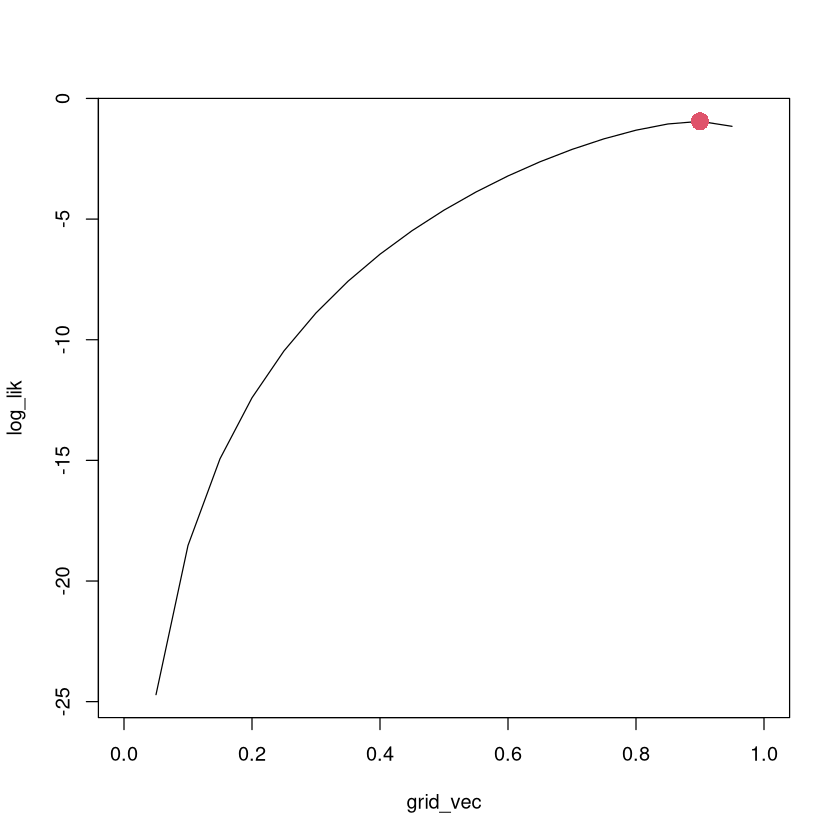

In [27]:
grid_size <- 0.05
grid_vec <- seq(0, 1, grid_size)
n <- 10
k <- 9
log_lik <- l(grid_vec, n, k)
plot(
  grid_vec,
  log_lik,
  type = "l"
)
max_ll_index <- which.max(log_lik)
arg_max <- grid_vec[max_ll_index]
arg_max
# graficar
points(
  arg_max,
  log_lik[max_ll_index],
  pch = 16,
  col = 2,
  cex = 2
)

En la práctica, este método puede ser muy costoso. Imaginar, por ejemplo, que se tiene que hacer una búsqueda para estimar 2 parámetros. Tendríamos que hacer combinaciones del grid de ambos parámetros. Este suele ser el método de fuerza bruta que se usa, en ocasiones, como primera aproximación o cuando no nos funciona ninguna otra cosa.

Es más eficiente usar un algoritmo de optimización, como `optimize()`. Tiene los siguientes argumentos:

```r
optimize(f, interval, ..., lower = min(interval), upper = max(interval),
         maximum = FALSE,
         tol = .Machine$double.eps^0.25)
         
f	
the function to be optimized. The function is either minimized or maximized over its first argument depending on the value of maximum.

interval	
a vector containing the end-points of the interval to be searched for the minimum.

...	
additional named or unnamed arguments to be passed to f.

lower	
the lower end point of the interval to be searched.

upper	
the upper end point of the interval to be searched.

maximum	
logical. Should we maximize or minimize (the default)?

tol	
the desired accuracy.

```

In [29]:
binom_mle <- function(k, n) {
  L <- function(theta) log(dbinom(k, n, theta))
  # usar solo interval entre 0 y 1 para theta
  # dado que buscamos un máximo, declaramos TRUE
  mle <- optimize(L, interval = c(0, 1), maximum = TRUE)
  mle
}
mle_theta <- binom_mle(9, 10)
mle_theta
# retorna dos valores: el valor que maximiza, y la fn objetivo (L)
# maximum corresponde al MLE, theta_hat. El valor de la objetivo
# variará en con respecto al valor encontrado antes porque omitimos el coeficiente binomial

$maximum
[1] 0.8999994

$objective
[1] -0.9482446

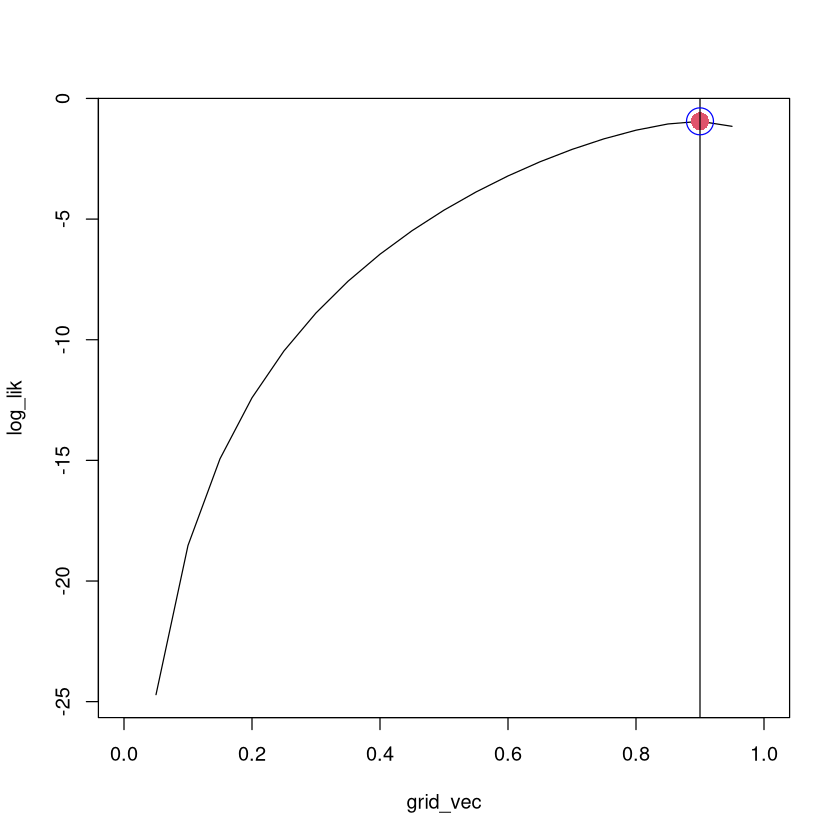

In [31]:
plot(
  grid_vec,
  log_lik,
  type = "l"
)
points(
  arg_max,
  log_lik[max_ll_index],
  pch = 16,
  col = 2,
  cex = 2
)
abline(v = mle_theta$maximum)
points(
  mle_theta$maximum,
  mle_theta$obj,
  col = 'blue',
  cex = 3
)